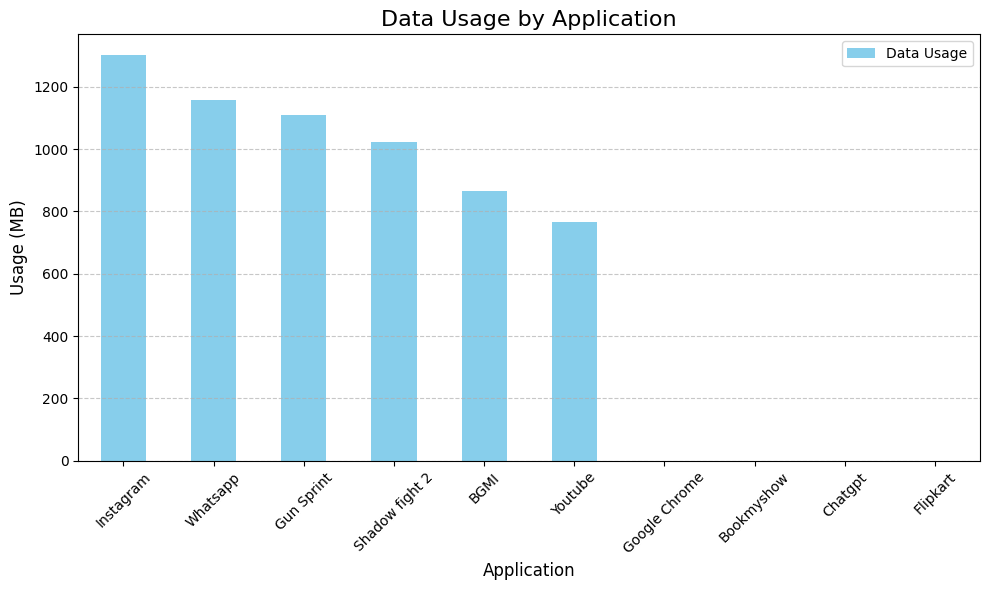

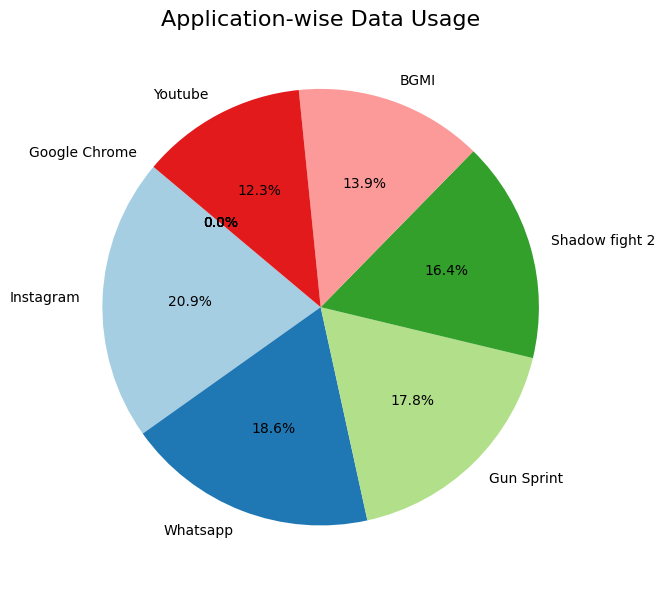

In [1]:
import tkinter as tk
from tkinter import messagebox
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt


def connect_to_db():
    try:
        connection = mysql.connector.connect(
            host="127.0.0.1",
            user="root",
            password="",  
            database="internet-data-usage"  
        )
        return connection
    except mysql.connector.Error as err:
        messagebox.showerror("Database Error", f"Error: {err}")
        return None


def login():
    username = username_entry.get()
    password = password_entry.get()

    if username and password:
        connection = connect_to_db()
        if connection:
            cursor = connection.cursor()
            query = "SELECT * FROM users WHERE username=%s AND password=%s"
            cursor.execute(query, (username, password))
            result = cursor.fetchone()
            connection.close()

            if result:
                messagebox.showinfo("Login Successful", f"Welcome, {username}!")
                show_main_menu(username)
            else:
                messagebox.showerror("Login Failed", "Invalid username or password.")
    else:
        messagebox.showerror("Login Error", "Please enter both username and password.")


def register_user():
    username = username_entry.get()
    password = password_entry.get()

    if username and password:
        connection = connect_to_db()
        if connection:
            cursor = connection.cursor()
            query = "INSERT INTO users (username, password) VALUES (%s, %s)"
            try:
                cursor.execute(query, (username, password))
                connection.commit()
                messagebox.showinfo("Registration Successful", "You can now log in.")
            except mysql.connector.IntegrityError:
                messagebox.showerror("Registration Error", "Username already exists.")
            finally:
                connection.close()
    else:
        messagebox.showerror("Register Error", "Please enter both username and password.")


def show_main_menu(username):
    login_frame.pack_forget()
    main_frame.pack(fill="both", expand=True)
    user_label.config(text=f"Welcome, {username}!")


def parse_usage(data):
    """Convert data usage strings like '10 KB', '49MB' into numeric MB."""
    try:
        value, unit = data.strip().split()
        value = float(value)
        if unit.lower() == "kb":
            return value / 1024  
        elif unit.lower() == "gb":
            return value * 1024  
        return value
    except:
        return 0  


def plot_graph(graph_type="bar"):
    try:
       
        df = pd.read_csv("Internet-Data-Usage.csv")
        df.columns = [col.strip() for col in df.columns]  
        df["DATA USAGE PER APPILICATION"] = df["DATA USAGE PER APPILICATION"].apply(parse_usage)

       
        aggregated_data = df.groupby("LIST OF APPILICATIONS")["DATA USAGE PER APPILICATION"].sum()

        
        aggregated_data = aggregated_data.sort_values(ascending=False).head(10)

        plt.figure(figsize=(10, 6))

        if graph_type == "bar":
            
            aggregated_data.plot(kind="bar", color="skyblue", label="Data Usage")
            plt.title("Data Usage by Application", fontsize=16)
            plt.xlabel("Application", fontsize=12)
            plt.ylabel("Usage (MB)", fontsize=12)
            plt.xticks(rotation=45, fontsize=10)
            plt.legend()
            plt.grid(axis="y", linestyle="--", alpha=0.7)

        elif graph_type == "pie":
            
            aggregated_data.plot(
                kind="pie",
                autopct='%1.1f%%',
                startangle=140,
                colors=plt.cm.Paired.colors,
                ylabel=""  
            )
            plt.title("Application-wise Data Usage", fontsize=16)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        messagebox.showerror("Plot Error", f"Error: {e}")


def display_data():
    try:
        df = pd.read_csv("Internet-Data-Usage.csv")
        top = tk.Toplevel(root)
        top.title("Data Display")

        text = tk.Text(top, wrap="none", font=("Courier", 10))
        text.insert("1.0", df.to_string(index=False))
        text.pack(fill="both", expand=True)
    except Exception as e:
        messagebox.showerror("Data Error", f"Error: {e}")



root = tk.Tk()
root.title("Data Usage Analyzer")
root.geometry("500x400")
root.resizable(False, False)
root.configure(bg="#f2f2f2")


login_frame = tk.Frame(root, bg="#f2f2f2")
tk.Label(login_frame, text="Data Usage Analyzer", font=("Helvetica", 18, "bold"), bg="#f2f2f2", fg="#333").pack(pady=20)

tk.Label(login_frame, text="Username:", bg="#f2f2f2", font=("Helvetica", 12)).pack(pady=5)
username_entry = tk.Entry(login_frame, width=30)
username_entry.pack(pady=5)

tk.Label(login_frame, text="Password:", bg="#f2f2f2", font=("Helvetica", 12)).pack(pady=5)
password_entry = tk.Entry(login_frame, width=30, show="*")
password_entry.pack(pady=5)

tk.Button(login_frame, text="Login", command=login, bg="#4caf50", fg="white", font=("Helvetica", 10, "bold"), width=12).pack(pady=10)
tk.Button(login_frame, text="Register", command=register_user, bg="#007bff", fg="white", font=("Helvetica", 10, "bold"), width=12).pack(pady=5)

login_frame.pack(fill="both", expand=True)


main_frame = tk.Frame(root, bg="#f2f2f2")
user_label = tk.Label(main_frame, text="", bg="#f2f2f2", font=("Helvetica", 14, "bold"), fg="#333")
user_label.pack(pady=20)

tk.Button(main_frame, text="Plot Bar Graph", command=lambda: plot_graph("bar"),
          bg="#4caf50", fg="white", font=("Helvetica", 10, "bold"), width=20).pack(pady=10)
tk.Button(main_frame, text="Plot Pie Chart", command=lambda: plot_graph("pie"),
          bg="#007bff", fg="white", font=("Helvetica", 10, "bold"), width=20).pack(pady=10)
tk.Button(main_frame, text="Show Data", command=display_data,
          bg="#ffc107", fg="white", font=("Helvetica", 10, "bold"), width=20).pack(pady=10)

root.mainloop()
